In [1]:
# basic imports for modelling notebook
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('../data/modelling_1_data.csv')

In [3]:
df.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date', 'month_sin', 'month_cos', 'arr_flights_ewma', 'arr_del15_ewma',
       'arr_cancelled_ewma', 'arr_diverted_ewma', 'arr_delay_ewma',
       'carrier_ct_ewma', 'weather_ct_ewma', 'nas_ct_ewma', 'security_ct_ewma',
       'late_aircraft_ct_ewma', 'carrier_delay_ewma', 'weather_delay_ewma',
       'nas_delay_ewma', 'security_delay_ewma', 'late_aircraft_delay_ewma'],
      dtype='object')

In [4]:
df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,carrier_ct_ewma,weather_ct_ewma,nas_ct_ewma,security_ct_ewma,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma
0,2018,2,9E,ABE,16.0,2.0,1.00,0.00,0.01,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9E,ABE,1.0,0.0,0.00,0.00,0.00,0.00,...,1.000000,0.000000,0.010000,0.000000e+00,0.990000,30.000000,0.00000,1.000000,0.000000,157.000000
2,2018,4,9E,ABE,54.0,3.0,1.78,0.00,0.32,0.00,...,0.500000,0.000000,0.005000,0.000000e+00,0.495000,15.000000,0.00000,0.500000,0.000000,78.500000
3,2018,5,9E,ABE,56.0,9.0,4.87,0.00,4.04,0.00,...,1.140000,0.000000,0.162500,0.000000e+00,0.702500,44.000000,0.00000,5.750000,0.000000,62.250000
4,2018,6,9E,ABE,13.0,1.0,0.00,0.27,0.73,0.00,...,3.005000,0.000000,2.101250,0.000000e+00,0.401250,184.000000,0.00000,77.375000,0.000000,34.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178742,2022,12,YV,YUM,18.0,4.0,1.00,0.00,0.04,0.00,...,0.659732,0.001032,0.147420,9.155273e-07,1.014621,73.950116,0.14000,14.440829,0.000092,94.889999
178743,2023,1,YV,YUM,52.0,3.0,1.00,0.00,0.00,0.00,...,0.829866,0.000516,0.093710,4.577637e-07,1.987311,53.475058,0.07000,9.220415,0.000046,159.945000
178744,2023,2,YV,YUM,30.0,8.0,1.33,0.00,2.67,0.00,...,0.914933,0.000258,0.046855,2.288818e-07,1.993655,102.237529,0.03500,4.610207,0.000023,195.472500
178745,2023,3,YV,YUM,31.0,10.0,0.70,0.00,0.86,0.19,...,1.122466,0.000129,1.358427,1.144409e-07,2.996828,68.118765,0.01750,29.805104,0.000011,497.236250


In [5]:
# Step 1: Split train and test
train_val_df = df[df['year'] < 2023].copy()
test_df = df[df['year'] == 2023].copy()

# Step 2: Drop unwanted columns
drop_cols = ['month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date']
target = 'arr_delay'

# Optional: keep row index for final mapping
train_val_df = train_val_df.reset_index(drop=True)


In [6]:
test_df.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date', 'month_sin', 'month_cos', 'arr_flights_ewma', 'arr_del15_ewma',
       'arr_cancelled_ewma', 'arr_diverted_ewma', 'arr_delay_ewma',
       'carrier_ct_ewma', 'weather_ct_ewma', 'nas_ct_ewma', 'security_ct_ewma',
       'late_aircraft_ct_ewma', 'carrier_delay_ewma', 'weather_delay_ewma',
       'nas_delay_ewma', 'security_delay_ewma', 'late_aircraft_delay_ewma'],
      dtype='object')


🌀 Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 26033, number of used features: 18
[LightGBM] [Info] Start training from score 3169.691814
✅ LightGBM MAE: 1776.84
✅ XGBoost MAE: 1739.57

🌀 Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 52062, number of used features: 18
[LightGBM] [Info] Start training from score 4189.475952
✅ LightGBM MAE: 1105.23
✅ XGBoost MAE: 1123.61

🌀 Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

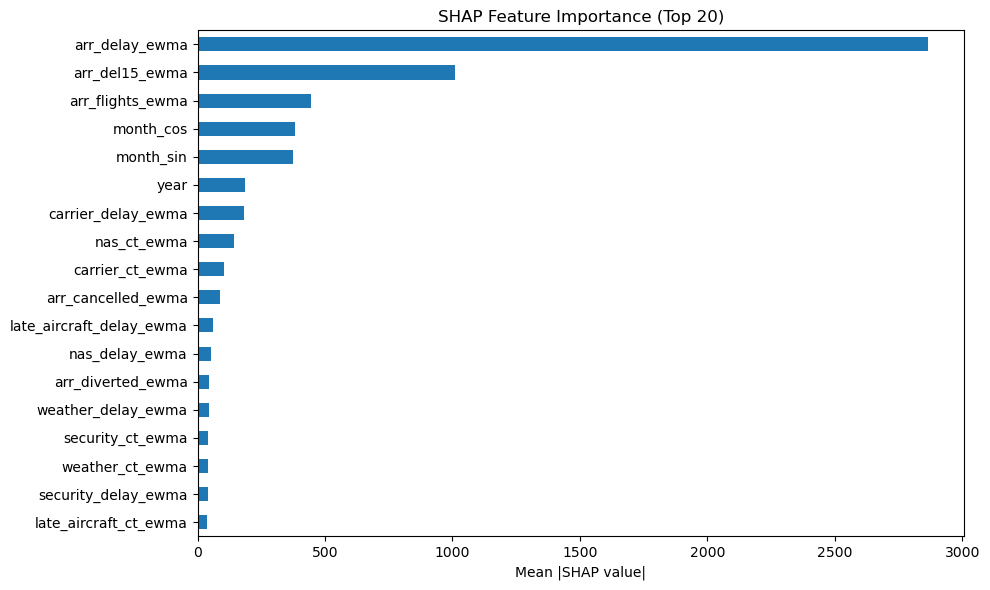


📌 SHAP Waterfall Plot for One Prediction:


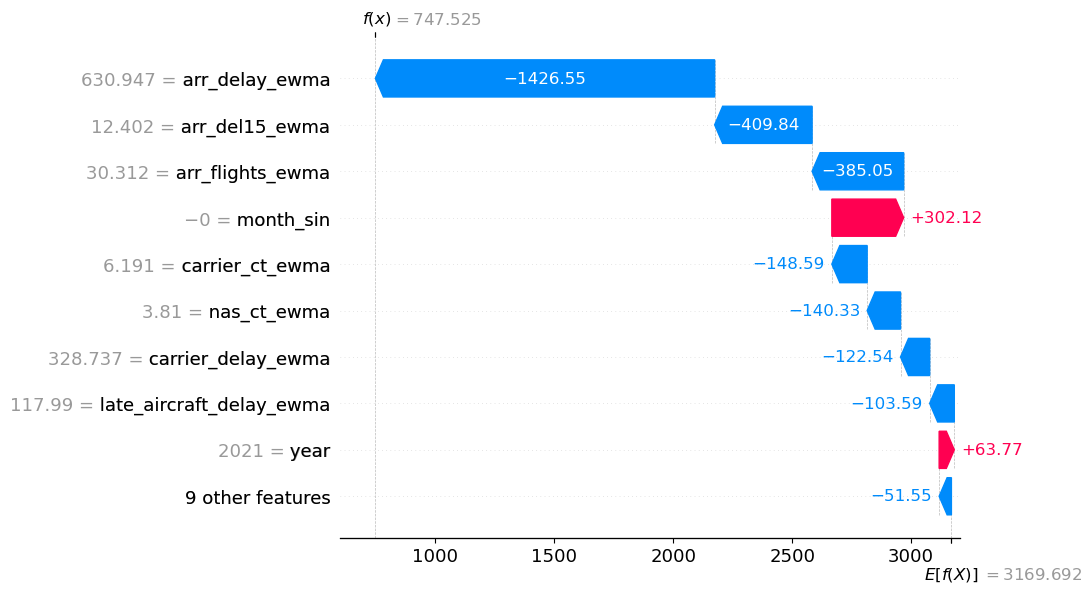

In [7]:
# Step 3: Define features
X = train_val_df.drop(columns=drop_cols + [target])
y = train_val_df[target]

# Step 4: Time-based cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Results storage
model_results = {
    'lgbm': {'maes': []},
    'xgb': {'maes': []}
}
shap_feature_importance_list = []
example_shap_values = None  # For waterfall plot

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\n🌀 Fold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # ========== LightGBM ==========
    lgb_model = LGBMRegressor(random_state=42)
    lgb_model.fit(X_train, y_train)
    lgb_preds = lgb_model.predict(X_val)
    lgb_mae = mean_absolute_error(y_val, lgb_preds)
    model_results['lgbm']['maes'].append(lgb_mae)

    # ========== XGBoost ==========
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_val)
    xgb_mae = mean_absolute_error(y_val, xgb_preds)
    model_results['xgb']['maes'].append(xgb_mae)

    # ========== SHAP for LGBM ==========
    # Sample for speed
    X_sample = X_train.sample(n=min(5000, len(X_train)), random_state=42)
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_sample)

    # Mean absolute SHAP per feature
    mean_shap_importance = np.abs(shap_values).mean(axis=0)
    shap_feature_importance_list.append(pd.Series(mean_shap_importance, index=X.columns))
    
    # Save one example for waterfall plot
    if example_shap_values is None:
        example_shap_values = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value,
                                               data=X_sample.iloc[0], feature_names=X_sample.columns)

    # ========== Fold Results ==========
    print(f"✅ LightGBM MAE: {lgb_mae:.2f}")
    print(f"✅ XGBoost MAE: {xgb_mae:.2f}")

# ========== Final Results ==========
print("\n📊 Final Cross-Validation Results:")
print(f"LightGBM Mean MAE: {np.mean(model_results['lgbm']['maes']):.2f}")
print(f"XGBoost Mean MAE: {np.mean(model_results['xgb']['maes']):.2f}")

# ========== SHAP Bar Plot ==========
mean_shap_df = pd.concat(shap_feature_importance_list, axis=1).mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mean_shap_df.head(20).plot(kind='barh')
plt.title("SHAP Feature Importance (Top 20)")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ========== SHAP Waterfall Plot ==========
print("\n📌 SHAP Waterfall Plot for One Prediction:")
shap.plots.waterfall(example_shap_values)